In [1]:
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [2]:
df = pd.read_csv('./cleaned_data.csv')
df = df['close'].values

In [3]:
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.008435
p-value: 0.750176


In [4]:
scaler = MinMaxScaler()
train = df[:-15]
test = df[-15:]
# train = train.reshape(-1,1)
# test = test.reshape(-1,1)
# scaler = scaler.fit(train)
# train_normalized = scaler.transform(train).squeeze()
# test_normalized = scaler.transform(test).squeeze()
train_normalized = train

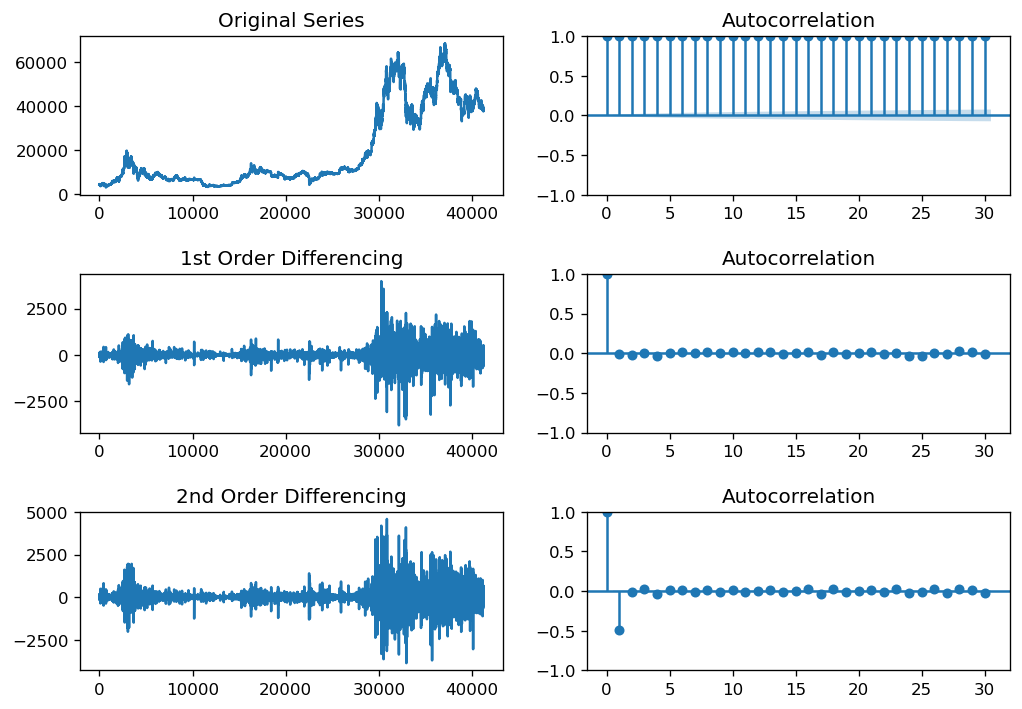

In [5]:
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':120})
fig, axes = plt.subplots(3, 2, sharex=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
axes[0, 0].plot(train_normalized)
axes[0, 0].set_title('Original Series')
plot_acf(train_normalized, ax=axes[0, 1], lags=30)


# 1st Differencing
axes[1, 0].plot(np.diff(train_normalized))
axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(train_normalized), ax=axes[1, 1],lags=30)


# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(train_normalized)))
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(train_normalized)), ax=axes[2, 1],lags=30)

plt.show()


C:\Users\Athra\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


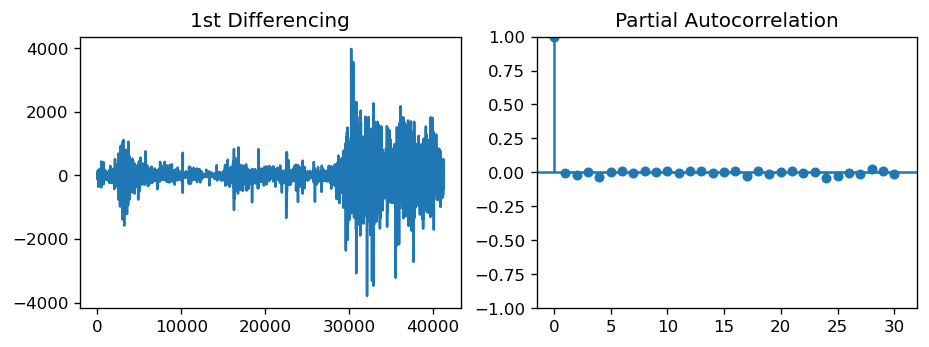

In [6]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(np.diff(train_normalized)) 
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(np.diff(train_normalized), ax=axes[1], lags=30)

plt.show()

In [7]:
#ARIMA
model = ARIMA(train_normalized, order=(1,1,1), seasonal_order=(1, 1, 1, 7))
# model = ARIMA(train_normalized, order=(1,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                               y   No. Observations:                41262
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood             -280344.788
Date:                         Sun, 09 Oct 2022   AIC                         560699.577
Time:                                 23:01:01   BIC                         560742.714
Sample:                                      0   HQIC                        560713.211
                                       - 41262                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9624      0.014     69.835      0.000       0.935       0.989
ma.L1         -0.9658      0.013    -73.093      0.000      -0.992      -0.940
ar.S.L7       -0.0003      0.002     -0.152      0.879      -0.005       0.004
ma.S.L7       -0.9998      0.000  -3653.392      0.000      -1.000      -0.999
sigma2      4.672e+04     85.317    547.555      0.000    4.65e+04    4.69e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):           1440144.28
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):              10.16   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

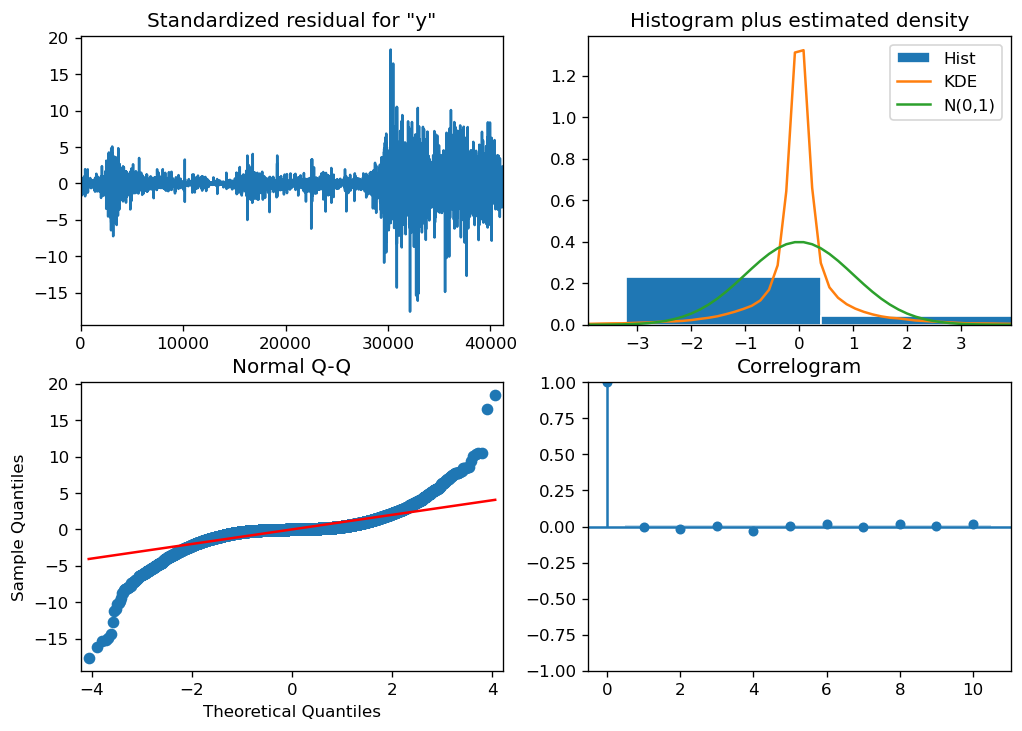

In [8]:
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':120})
model_fit.plot_diagnostics()
plt.show()

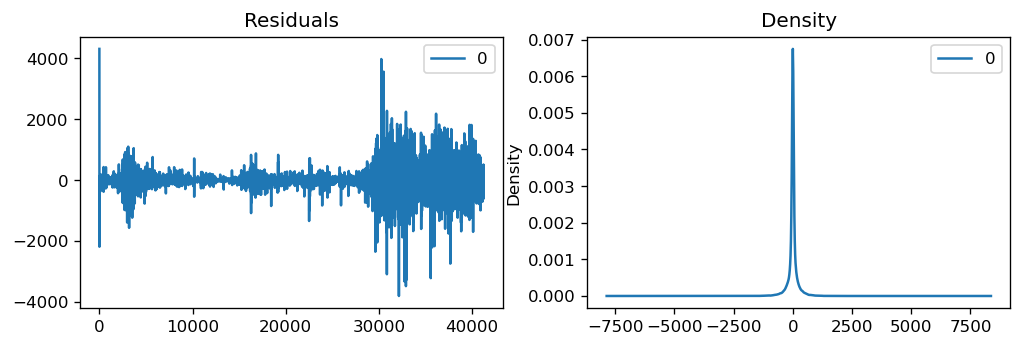

In [9]:
plt.rcParams.update({'figure.figsize':(10,3)})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [10]:
fc = model_fit.forecast(15, alpha=0.05)

In [11]:
# forecast, conf = fc.predicted_mean, fc.conf_int()
# fc_series = pd.Series(fc, index=test.index)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)

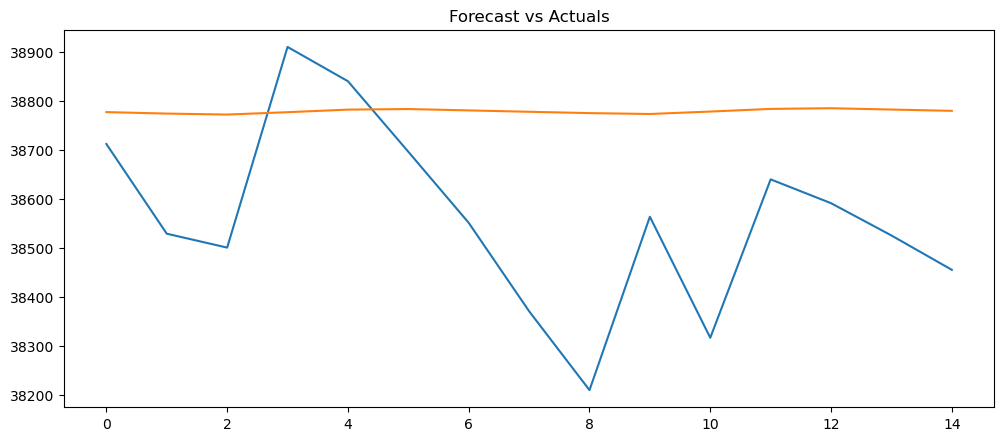

In [12]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test, label='actual')
plt.plot(fc, label='forecast')
plt.title('Forecast vs Actuals')
plt.show()

## AUTO ARIMA ##

In [13]:
threshold = -15
df = pd.read_csv('./cleaned_data_daily.csv')
df_ = np.log(df['close'].values)
train = df_[:threshold]
test = df_[threshold:]
scaler = StandardScaler()
train = scaler.fit_transform(train.reshape(-1,1)).squeeze()
test = scaler.transform(test.reshape(-1,1)).squeeze()

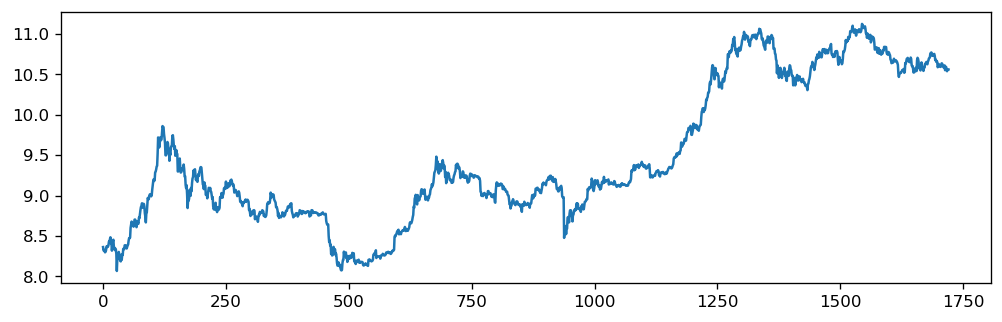

In [14]:
plt.plot(df_)

In [15]:
model = pm.auto_arima(train,
                      start_p=10,
                      start_q=10,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, 
                      max_q=10, 
                      m=24,             # frequency of series
                      d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-5445.197, Time=0.22 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=-5443.368, Time=0.70 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=-5441.651, Time=5.73 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=-5443.386, Time=0.89 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=-5441.401, Time=1.42 sec
 ARIMA(0,1,0)(1,0,2)[24] intercept   : AIC=-5439.660, Time=7.24 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=-5441.626, Time=2.77 sec
 ARIMA(0,1,0)(2,0,1)[24] intercept   : AIC=-5439.616, Time=10.55 sec
 ARIMA(0,1,0)(2,0,2)[24] intercept   : AIC=-5437.564, Time=5.36 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=-5448.231, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-5446.362, Time=1.22 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=-5444.567, Time=17.08 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=-5446.364, Time=1.40 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=-5444.376, Time=2.25 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=-54

MemoryError: Unable to allocate 32.5 MiB for an array with shape (50, 50, 1706) and data type float64

In [16]:
model.summary()
fc = model.predict(n_periods=-threshold)
fc

AttributeError: 'ARIMA' object has no attribute 'summary'

In [25]:
# model_ = sm.tsa.arima.ARIMA(train, order = (6,1,10), seasonal_order=(0, 0, 0, 7))
# fitted = model_.fit()
# fc_ = fitted.get_forecast(-threshold)
# fc_ = (fc_.summary_frame(alpha=0.05))
# fc_

In [26]:
appended_org = np.concatenate((train[-20:],test))
appended_fc = np.concatenate((train[-20:],fc))

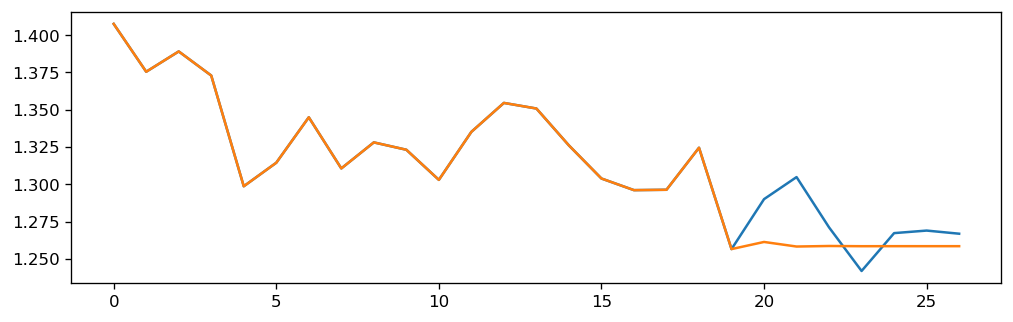

In [27]:
plt.plot(appended_org)
plt.plot(appended_fc)
plt.show()